# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import random
import itertools
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IPipe

from scipy.stats import ttest_ind

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<H1> Cleaning, Preparation and Exploration of Data </H1>

In [2]:
#Focus on data from the training period
splitter=transcript.time >= 24*7*3
test_transcript=transcript[splitter].copy()
transcript=transcript[~splitter]

#Prepare offer portfolio 
portfolio=portfolio.set_index('id')
portfolio.index.rename('offer_id', inplace=True)

dummies=portfolio.channels.apply(lambda x: pd.Series(len(x)*[1], x)).fillna(0)
portfolio=pd.concat([portfolio.drop('channels', axis=1), dummies], axis=1)
portfolio['name']=portfolio[['offer_type','reward', 'difficulty', 'duration']].astype(str).apply(','.join, axis=1)
portfolio.sort_values(['offer_type','reward','difficulty'])

,reward,difficulty,duration,offer_type,email,mobile,social,web,name
offer_id,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,"bogo,5,5,7"
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1.0,1.0,1.0,1.0,"bogo,5,5,5"
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1.0,1.0,1.0,0.0,"bogo,10,10,7"
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1.0,1.0,1.0,1.0,"bogo,10,10,5"
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1.0,1.0,1.0,1.0,"discount,2,10,10"
2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1.0,1.0,0.0,1.0,"discount,2,10,7"
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1.0,1.0,1.0,1.0,"discount,3,7,7"
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1.0,0.0,0.0,1.0,"discount,5,20,10"
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1.0,1.0,0.0,1.0,"informational,0,0,4"


In [3]:
#Prepare Profile DataFrama
profile=profile.set_index('id')
dates=profile.became_member_on.apply(lambda x: dt.strptime(str(x), '%Y%m%d'))
profile.became_member_on=dates
profile['account_age']=np.round((dt.now()-profile.became_member_on).apply(lambda x: x.days)/365)
profile.head()

,gender,age,became_member_on,income,account_age
id,,,,,
68be06ca386d4c31939f3a4f0e3dd783,None,118,2017-02-12,NaN,4.0
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,4.0
38fe809add3b4fcf9315a9694bb96ff5,None,118,2018-07-12,NaN,3.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,4.0
a03223e636434f42ac4c3df47e8bac43,None,118,2017-08-04,NaN,4.0


<AxesSubplot:xlabel='age', ylabel='Density'>

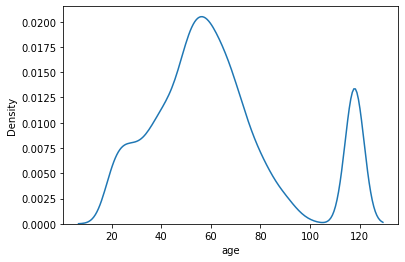

In [4]:
sns.kdeplot(profile.age)

In [5]:
profile.loc[profile.age == 118,'age']=np.nan

In [6]:
profile.isnull().sum()

gender              2175
age                 2175
became_member_on       0
income              2175
account_age            0
dtype: int64

There's about 2000 people for whom we have basically no user data. We'll just drop these for most applications.

In [7]:
profile=profile.dropna()

In [8]:
def pull_event(event, df=transcript, parser=lambda x: x['offer id'], label='offer_id'):
    """Pulls data for given event type"""
    events=df[df.event==event].copy()
    events[label]=events.value.apply(parser)
    return events.drop(['value', 'event'], axis=1)

In [9]:
#Prepare Transaction Data
transactions=pull_event('transaction', parser=lambda x: x['amount'], label='amount')
transactions.set_index('person', inplace=True)
transactions.index.name='id'

<AxesSubplot:xlabel='time'>

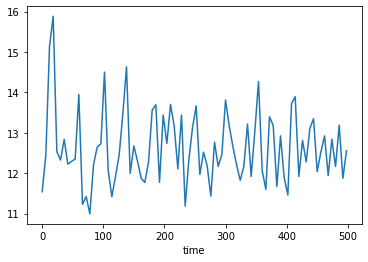

In [10]:
transactions.groupby('time').amount.mean().plot()

In [11]:
spend=transactions.groupby(level=0).sum().amount
spend.name='spend'

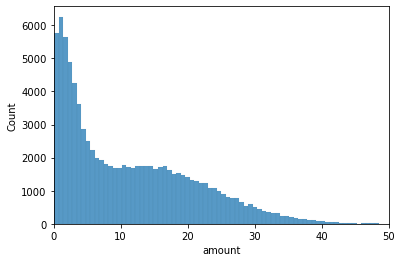

In [12]:
g=sns.histplot(transactions.amount)
g.set_xlim(0,50);

In [13]:
profile=profile.merge(spend, how='left', left_index=True, right_index=True).sort_values('spend', ascending=False).fillna(0)

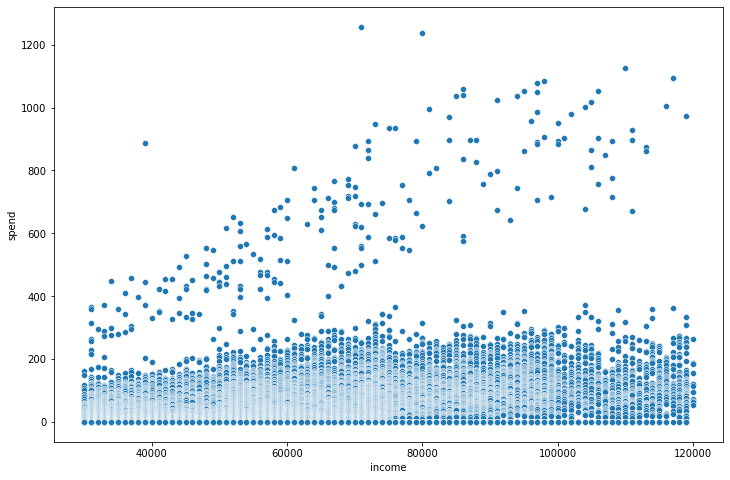

In [14]:
plt.subplots(figsize = (12,8))
sns.scatterplot(data=profile, x='income', y='spend');

There's a very noticeable group of people with very high sepnd, especially compared to income. Although we are unlikely to be able to use raw spend and transaction data to predict offer uptake (since this data is partially a function of offers completed), these kinds of groupings might be usefl. 

In [15]:
big_spenders=profile.dropna()[profile.dropna().spend >= transactions.amount.mean()*30]

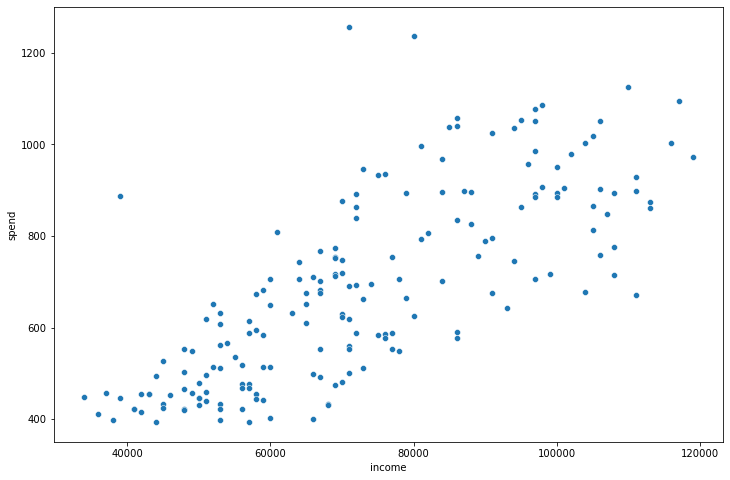

In [16]:
plt.subplots(figsize = (12,8))
sns.scatterplot(data=big_spenders, x='income', y='spend');

In [17]:
profile['big_spender']=[ x in big_spenders.index for x in profile.index]

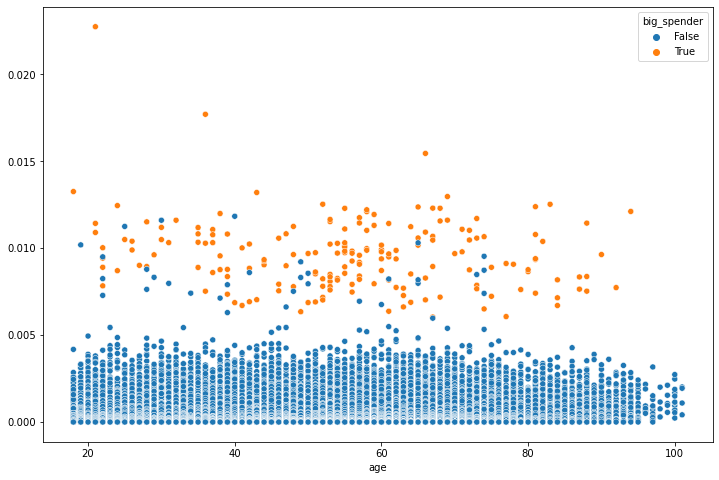

In [18]:
plt.subplots(figsize = (12,8))
sns.scatterplot(y=profile.spend/profile.income, x=profile.age, hue=profile.big_spender);

In [19]:
def drop_users(df, profile=profile):
    """Drop users we removed from profile df"""
    idx=profile.reindex(index=df.person.unique()).dropna().index
    df=df.set_index('person')
    df=df.loc[idx]
    return df.reset_index()

In [20]:
offers_made=pull_event('offer received')
offers_received=offers_made.merge(portfolio, left_on='offer_id', right_index=True)
offers_received=drop_users(offers_received)
offers_made=offers_made.groupby(['offer_id','time']).count().person
offers_made.name='count'

offers_made.head(10)

offer_id                          time
0b1e1539f2cc45b7b9fa7c272da2e1d7  0       1297
                                  168     1245
                                  336     1322
                                  408     1269
2298d6c36e964ae4a3e7e9706d1fb8c2  0       1221
                                  168     1250
                                  336     1301
                                  408     1274
2906b810c7d4411798c6938adc9daaa5  0       1257
                                  168     1270
Name: count, dtype: int64

<AxesSubplot:xlabel='time', ylabel='Count'>

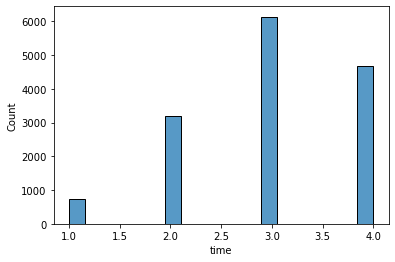

In [21]:
sns.histplot(offers_received.groupby('person').time.count())

In [22]:
#Prepare data on offer completion
offers_completed=pull_event('offer completed', parser=lambda x: x['offer_id'])
offers_completed=offers_completed.merge(portfolio.reward, left_on='offer_id', right_index=True)
offers_completed=drop_users(offers_completed)

In [23]:
transactions=transactions.reset_index().merge(offers_completed[['person','time', 'reward']], 
                                 left_on=['id','time'], right_on=['person','time'], 
                                 how='left').set_index('id').drop('person', axis=1).fillna(0)

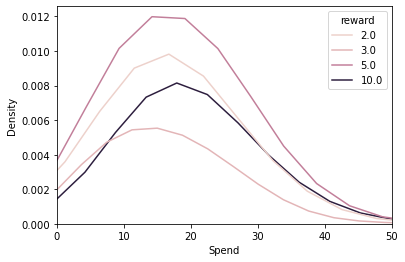

In [24]:
g=sns.kdeplot(data=transactions[transactions.reward != 0], x='amount', hue='reward')
g.set(xlim=(0,50), xlabel='Spend');

In [25]:
#Collect reward and completion data
max_rewards=offers_received.groupby('person').reward.sum()
max_rewards.name='max_reward'
number_completed=(transactions.reward > 0).groupby('id').sum()
number_completed.name='#_completed'
number_transactions=transactions.groupby('id').time.count()
number_transactions.name='#_transactions'
rewards=offers_completed.groupby('person').reward.sum()

In [26]:
idx=profile.index

In [27]:
profile=pd.concat([profile, rewards, max_rewards, number_completed, number_transactions], axis=1).fillna(0).loc[idx]

In [28]:
reward_profile=profile.groupby(['reward', 'max_reward']).spend.mean().apply(lambda x: np.log(x))
reward_profile.name='log spend'
reward_profile=reward_profile.reset_index()

In [29]:
#Fit Linear Model on Rewards claim
LR=LinearRegression(fit_intercept=False)
LR.fit(profile.max_reward.values.reshape(-1,1), profile.reward)
m=LR.predict([[1]])[0]

Best fit: y=0.5274372751974755x


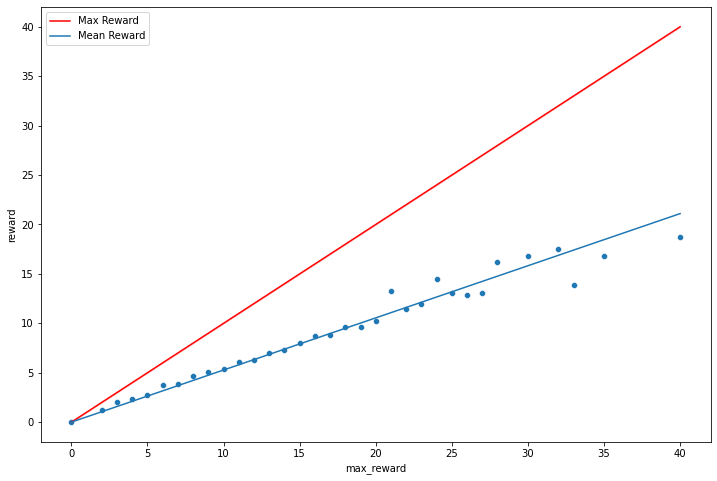

In [30]:
plt.subplots(figsize = (12,8))
g=sns.scatterplot(data=profile.groupby('max_reward').mean().reward.reset_index(), x='max_reward', y='reward')
sns.lineplot(data=profile, x='max_reward', y='max_reward', color='red')
sns.lineplot(x=range(0,41), y=LR.predict(np.array(range(0,41)).reshape(-1,1)))

plt.legend(['Max Reward', 'Mean Reward'])
print(f'Best fit: y={m}x') 

It seems that about 50% of rewards are claimed by value. The poor fit towards the end is likely due, at least in part, to fewer people being offered the such large max rewards.

<h2> P_testing Offer Effectiveness </h2>

In [31]:
offers_received['end']=offers_received.time+offers_received.duration*24

In [32]:
def pull_relevant(offer,start,end):
    """Pulls null/offered group for an offer within a given time range (start,end)"""
    
    
    is_not_null=offers_received.set_index('person').apply(
        lambda row: start <= row.time <= end or start <= row.end <= end, axis=1).groupby('person').any()
    not_null=profile.loc[is_not_null.index][is_not_null]
    null=profile.drop(not_null.index)
    offered=offers_received.set_index(['time','offer_id']).sort_index().loc[(start,offer),'person'].values
    offered=not_null.loc[offered]
    
    period_transactions=transactions[(start <= transactions.time) & (transactions.time <= end)].amount
    
    merge_group = lambda L,R: L.merge(R, left_index=True, right_index=True, how='left').groupby(level=0)
    collate =  lambda X: pd.DataFrame([X.count(),X.sum(),X.mean()], index=['count', 'total', 'mean']).transpose().fillna(0)
    
    null_transactions=merge_group(null,period_transactions).amount
    null=null.merge(collate(null_transactions), left_index=True, right_index=True)
    #null.join(null,collate(null_transactions))
    
    offered_transactions=merge_group(offered,period_transactions).amount
    offered=offered.merge(collate(offered_transactions), left_index=True, right_index=True)
    
    return null,offered
    
                        

In [33]:
def t_test(null, offered, cost):
    """Perform t_tests for effectiveness. Checks if mean, total spend and number of transactions
    are signficantly different. Also checks total minus the cost of offer reward. 
    
    Paramters:
    null (df): null group for t_test
    offerd (df): offered group for t_test 
    cost (int): cost of offer reward
    
    returns:
    p_series (series): results of t_tests and relevant statistics
    """
    cols=['age', 'income']
    p_dict={('p_'+col):ttest_ind(null[col].dropna(), offered[col].dropna()).pvalue for col in cols}
    
    
    def t_test_1_sided(a,b,c):
        
        p=ttest_ind(a.dropna()-c, b.dropna(), equal_var=False).pvalue/2
        if a.mean()-c < b.mean():
            p=1-p
        return -np.log(p)
    
    p_dict['p_total-cost']=t_test_1_sided(offered['total'], null['total'], cost)
    p_dict['total-cost']=offered['total'].mean()-null['total'].mean()-cost
    
    for col in ['total','mean', 'count']:
        p_dict['p_'+col]=t_test_1_sided(offered[col],null[col],0)
        p_dict['offered_'+col]=offered[col].mean()
        p_dict['null_'+col]=null[col].mean()
        
    
    p_series=pd.Series(p_dict)
    
    return p_series 

In [34]:
offers_made=offers_made.reset_index().set_index('offer_id').join(portfolio, how='left')

In [35]:
offers_made['end']=offers_made.time+offers_made.duration*24

In [36]:
all_null=[]
all_offered=[]
for i in offers_made.reset_index().index:
    row = offers_made.iloc[i]
    null, offered =pull_relevant(row.name,row.time,row.end)
    null['offer']=row.name
    offered['offer']=row.name
    all_null.append(null)
    all_offered.append(offered)
    
null=pd.concat(all_null).set_index('offer')
offered=pd.concat(all_offered).set_index('offer')

In [37]:
p_dict={}
for offer in portfolio.index:
    p_dict[offer]=t_test(null.loc[offer], 
            offered.loc[offer],
            portfolio.loc[offer,'reward'])

<ipython-input-33-e9ba0b05bc80>:22: RuntimeWarning: divide by zero encountered in log
  return -np.log(p)


In [38]:
res_df=pd.DataFrame(p_dict).transpose()
res_df.index=portfolio.name.values
res_df.sort_values('total-cost', ascending=False)

,p_age,p_income,p_total-cost,total-cost,p_total,offered_total,null_total,p_mean,offered_mean,null_mean,p_count,offered_count,null_count
"discount,2,10,10",0.373081,0.513743,251.415865,30.652512,283.408413,46.875874,14.223363,36.634555,13.352046,8.858298,inf,3.280471,1.043826
"discount,3,7,7",0.472075,0.418224,187.476382,18.569828,249.576284,33.467657,11.897829,32.359681,11.840403,8.185221,inf,2.492615,0.867023
"bogo,5,5,5",0.627717,0.307679,92.664772,12.317879,177.398431,26.940110,9.622231,52.153454,11.919873,6.976287,inf,1.866667,0.705882
"discount,2,10,7",0.888283,0.627830,80.655369,12.179083,107.848849,26.076912,11.897829,21.634059,11.161493,8.185221,377.954748,1.737208,0.867023
"discount,5,20,10",0.367586,0.735100,53.657970,11.965843,104.198406,31.189206,14.223363,19.425179,12.090161,8.858298,332.601467,1.965403,1.043826
"bogo,10,10,7",0.949229,0.115336,48.955730,9.915389,184.972483,31.813218,11.897829,29.090939,11.862773,8.185221,inf,2.413184,0.867023
"bogo,5,5,7",0.725452,0.584020,40.097766,7.913657,101.293686,24.811486,11.897829,14.263930,10.484330,8.185221,372.677502,1.742637,0.867023
"informational,0,0,3",0.952612,0.920038,108.007086,6.960021,108.007086,13.918947,6.958925,49.624650,8.354929,5.289228,420.722524,1.116625,0.522302
"bogo,10,10,5",0.178025,0.665663,34.850332,6.925740,189.016236,26.547971,9.622231,59.501045,11.383595,6.976287,inf,1.933272,0.705882
"informational,0,0,4",0.489737,0.747444,59.748068,5.720949,59.748068,13.865758,8.144809,25.925570,8.166071,6.139471,220.613258,1.012556,0.597345


The table above shows $-log(p)$ for various $p$-tests. A score above 3 can be considered significant. The key figures here are that age and income seem similarly distributed across null and test groups; and that the $p_{total-cost}$ value is always large. This means that we can reject the hypthesis that the total spend of people to whom the offer was made was lower than the total spend of those who it wasn't plus the monetary value of the offer itself. That is the impact of the offer was both significant and meaningful. Although these tests were aggregated into one number for each offer, the information used was only from the periods in which the offer was active. 

Notcieably there was an increase in both mean spend and number of transactions among offered groups. 

In [39]:
pd.concat([(res_df['total-cost']/portfolio.set_index('name').duration).sort_values(ascending=False),
           portfolio.set_index('name')], axis=1)

,0,reward,difficulty,duration,offer_type,email,mobile,social,web
"discount,2,10,10",3.065251,2,10,10,discount,1.0,1.0,1.0,1.0
"discount,3,7,7",2.652833,3,7,7,discount,1.0,1.0,1.0,1.0
"bogo,5,5,5",2.463576,5,5,5,bogo,1.0,1.0,1.0,1.0
"informational,0,0,3",2.320007,0,0,3,informational,1.0,1.0,1.0,0.0
"discount,2,10,7",1.739869,2,10,7,discount,1.0,1.0,0.0,1.0
"informational,0,0,4",1.430237,0,0,4,informational,1.0,1.0,0.0,1.0
"bogo,10,10,7",1.416484,10,10,7,bogo,1.0,1.0,1.0,0.0
"bogo,10,10,5",1.385148,10,10,5,bogo,1.0,1.0,1.0,1.0
"discount,5,20,10",1.196584,5,20,10,discount,1.0,0.0,0.0,1.0
"bogo,5,5,7",1.130522,5,5,7,bogo,1.0,1.0,0.0,1.0


While all the measures are deemed effective by our p_tests, there does seem to be differences in performance. Roughly speaking it looks like the 2,10,10 discount performs best, but comparing the offers like this is on shaky statistical footing. There may be other factors impacting performance, e.g. people might be more likely to buy coffee on a monday, so offers which include a (or multiple) mondays might get a boost. 

<h2> Clustering for Big Spenders </h2>

In [40]:
profile['Male']=profile.gender=='M'
profile['Female']=profile.gender=='F'
profile.drop('gender', axis=1,inplace=True)

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [42]:
profile_pred_dat=profile.copy()[['income', '#_transactions']]
profile_pred_dat.income=profile_pred_dat.income.apply(np.log)

In [43]:
profile_pred_dat['prop_spend']=profile.spend/profile.income
profile_pred_dat['mean_spend']=(profile.spend/profile['#_transactions']).fillna(0)

In [44]:
def km(n):
    """Kmeans with n clusters"""
    kmeans_pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n))
    ])
    return kmeans_pipe

In [45]:
inertias=[]

for n in range(1,11):
    kmeans=km(n)
    kmeans.fit(profile_pred_dat)
    inertias.append(kmeans['kmeans'].inertia_)

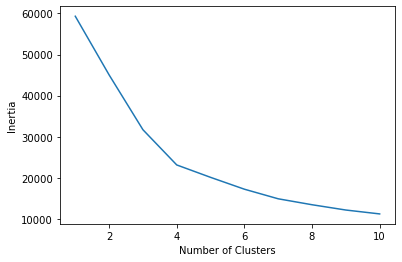

In [46]:
plt.plot(range(1,11),inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [47]:
kmeans_pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4, random_state=111))
])

In [48]:
kmeans_pipe.fit(profile_pred_dat)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=111))])

In [49]:
profile['cluster']=kmeans_pipe.predict(profile_pred_dat)

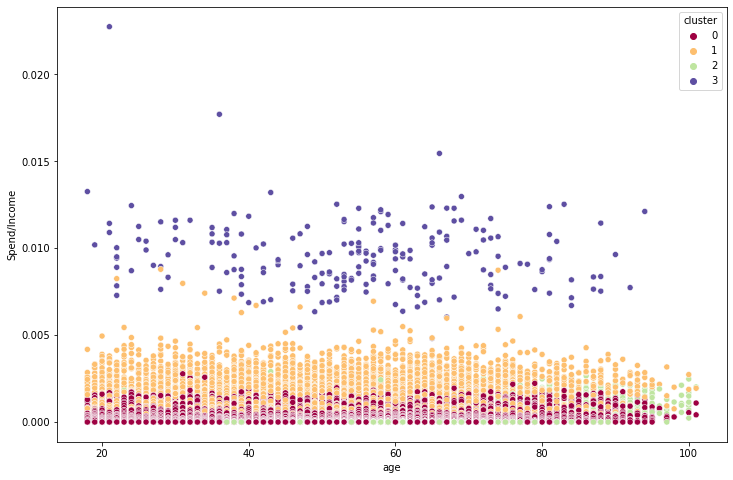

In [50]:
sns.color_palette("Spectral")
plt.subplots(figsize = (12,8))
sns.scatterplot(y=profile.spend/profile.income, x=profile.age, hue=profile.cluster, palette='Spectral');
plt.ylabel('Spend/Income');

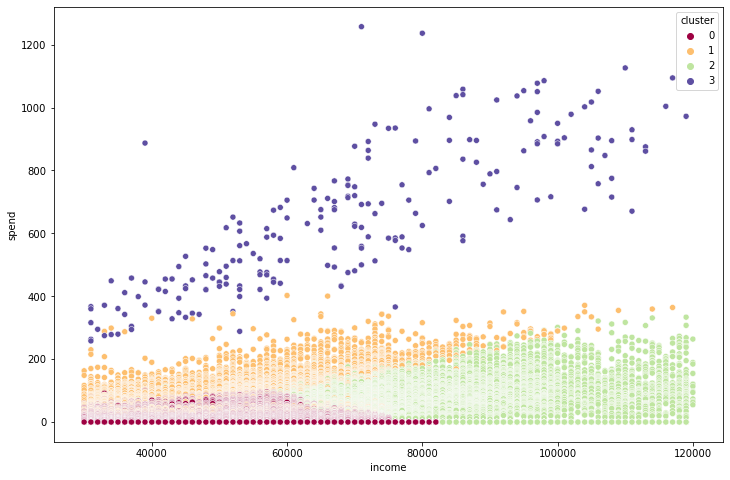

In [51]:
plt.subplots(figsize = (12,8))
sns.scatterplot(data=profile, x='income', y='spend', hue=profile.cluster,palette='Spectral');

In [52]:
#Find cluster which corresponds to big_spender
profile.big_spender=profile.big_spender.astype(bool)

comparison=profile.groupby('cluster').big_spender.mean().sort_values(ascending=False)
big_spender_cluster=comparison.index[0]
profile.big_spender=(profile.cluster==big_spender_cluster)
comparison

cluster
3    0.879808
1    0.000553
2    0.000000
0    0.000000
Name: big_spender, dtype: float64

In [53]:
profile['mean_spend']=(profile.spend/profile['#_transactions']).fillna(0)

(0.0, 20.0)

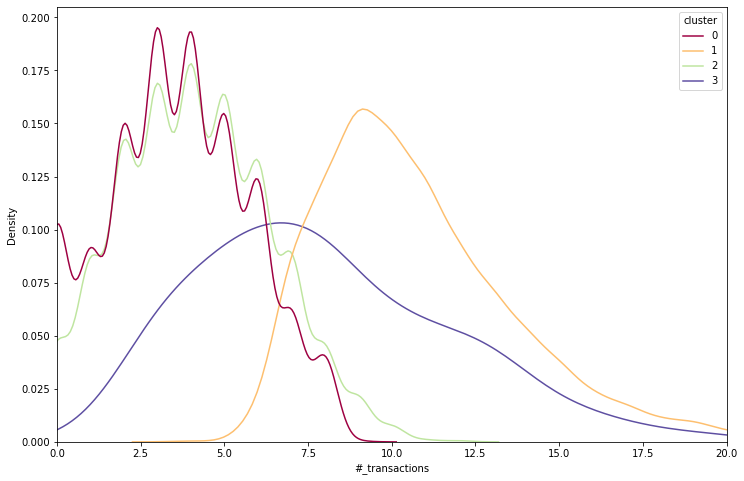

In [54]:
plt.subplots(figsize = (12,8))
g=sns.kdeplot(profile['#_transactions'], hue=profile.cluster, common_norm=False, palette='Spectral')
g.set_xlim(0,20)

(0.0, 100.0)

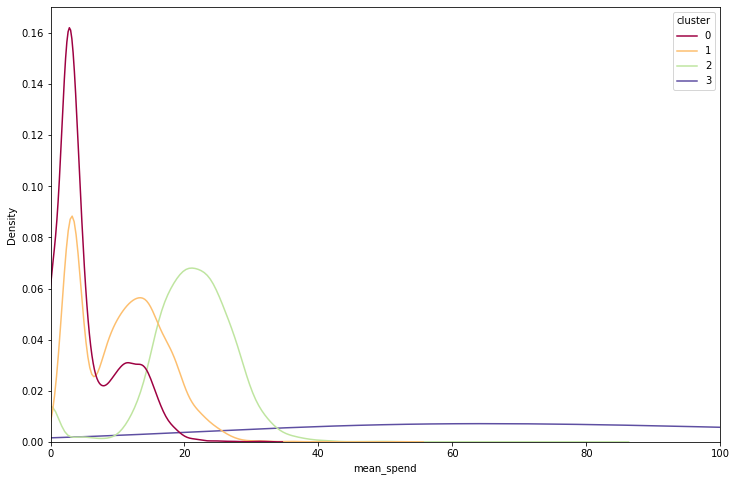

In [55]:
plt.subplots(figsize = (12,8))
g=sns.kdeplot(profile.mean_spend, hue=profile.cluster, common_norm=False, palette='Spectral')
g.set_xlim(0,100)

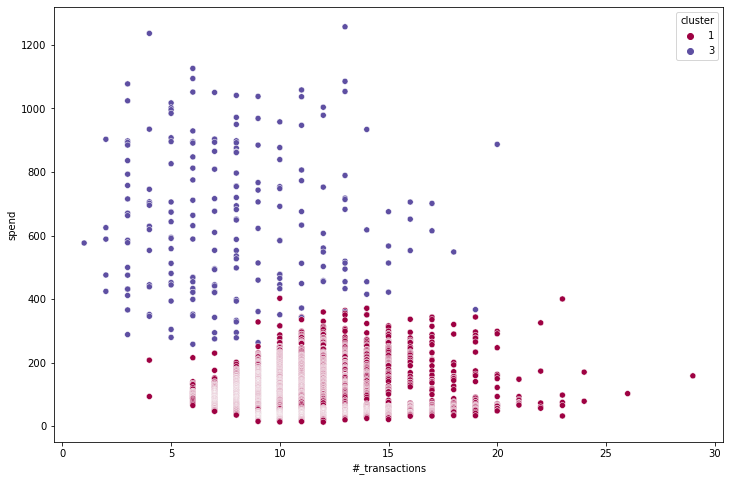

In [56]:
plt.subplots(figsize = (12,8))
g=sns.scatterplot(data=profile[(profile.cluster.apply(lambda x: x in comparison.index[:2]))], y='spend',
                  x= '#_transactions', hue='cluster', palette='Spectral')

These clusters all have quite different spending patterns, exactly as we wanted. The big_spender cluster in particular is very different, having totally different mean spend distribution and a distinct number of transaction distribution as well.

<h1> Offer Classification </h1>

<b> More Data Preparation </b>

In [57]:
offers_viewed=pull_event('offer viewed').set_index(['person', 'offer_id']).sort_index()

In [58]:
transactions=pull_event('transaction', parser=lambda x: x['amount'], label='spend')
offers_completed=offers_completed.merge(transactions, left_on=['person', 'time'], 
                                        right_on=['person', 'time']).set_index(['person', 'offer_id']).sort_index()

In [59]:
test_received=pull_event('offer received', df=test_transcript).set_index(['person', 'offer_id']).sort_index()
test_viewed=pull_event('offer viewed', df=test_transcript).set_index(['person', 'offer_id']).sort_index()
test_completed=pull_event('offer completed', df=test_transcript, 
                          parser=lambda x: x['offer_id'])

test_transactions=pull_event('transaction', df=test_transcript, parser=lambda x: x['amount'], label='spend')
test_completed=test_completed.merge(test_transactions, left_on=['person', 'time'], 
                                        right_on=['person', 'time']).set_index(['person', 'offer_id']).sort_index()

test_received=test_received.merge(portfolio, left_on='offer_id', right_index=True).reset_index()
test_received['end']=test_received.time+test_received.duration*24

In [60]:
def viewed_completed(row, viewed=offers_viewed, completed=offers_completed):
    """Check if offer (given as a row of offers_received) was viewed/completed"""
    
    offer=row.offer_id
    person=row.person
    start=row.time
    end=row.end
    
    def check(df):
        try:
            passed=df.loc[(person,offer)]
            passed=passed[(passed.time <= end) & (passed.time >= start)]
            return int(passed.shape[0] >0 )
        except:
            passed=0
        return passed
    return pd.Series([offer, person, start, check(viewed),check(completed)], index=['offer_id', 'person','time','viewed', 'Completed'])

In [61]:
#Create df of offer data and outcomes
offer_df=offers_received.merge(
    offers_received.apply(viewed_completed, axis=1),
    left_on=['offer_id', 'person', 'time'], right_on=['offer_id', 'person', 'time'])

test_vc=test_received.apply(lambda row: 
                    viewed_completed(row, viewed=test_viewed, completed=test_completed), axis=1)
test_offer_df=test_received.merge(
    test_vc,
    left_on=['offer_id', 'person', 'time'], right_on=['offer_id', 'person', 'time'])

In [62]:
informationals=portfolio.sort_values('offer_type').iloc[-2:].index

In [63]:
def pull_transactions(start, end, df=transactions):
    """Return transactions in a given time period"""
    return df[(df.time >= start) &(df.time <= end)]

In [64]:
#Informational offers need to be treated separately, we take any purchase to be a completion
for offer in informationals:
    times =offers_received.groupby(['offer_id', 'time', 'end']).count().loc[offer].index
    for start,end in [times[0]]:
        rel_df=offer_df[(offer_df[['offer_id', 'time', 'end']]==(offer,start,end)).all(axis=1)]
        rel_transactions=pull_transactions(start,end).groupby('person').count().spend
        completed=rel_df.merge(rel_transactions, left_on='person', right_index=True, how ='left').isnull().spend
        
        offer_df.loc[rel_df.index, 'Completed']=completed
    
    times =test_received.groupby(['offer_id', 'time', 'end']).count().loc[offer].index
    for start,end in [times[0]]:
        rel_df=test_offer_df[(test_offer_df[['offer_id', 'time', 'end']]==(offer,start,end)).all(axis=1)]
        rel_transactions=pull_transactions(start,end, df=test_transactions).groupby('person').count().spend
        completed=rel_df.merge(rel_transactions, left_on='person', right_index=True, how ='left').isnull().spend
        
        test_offer_df.loc[rel_df.index, 'Completed']=completed
    
offer_df.Completed=offer_df.Completed.astype(int)
test_offer_df.Completed=test_offer_df.Completed.astype(int)

In [65]:
profile.index.name='person'
profile=pd.get_dummies(profile, columns=['cluster'])

In [66]:
def drop_and_merge(cols, profile=profile):
    """Wrapper for drop column and merge function"""
    return lambda table: profile.drop(cols,axis=1).merge(table, 
                    left_index=True, right_on='person', how='inner').fillna(0)

profile_train_cols=['reward','max_reward', 
                    '#_completed', 'became_member_on', 'cluster_'+str(big_spender_cluster)]



In [67]:
df=pd.concat([offer_df,test_offer_df]).iloc[:,[0,2, -1,-2]].reset_index()
n=offer_df.shape[0]
df['train']=df.index <= n
df.drop('index', axis=1, inplace=True)
df.head()

,person,offer_id,Completed,viewed,train
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,True
1,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,0,1,True
2,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0,1,True
3,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,True
4,ebe7ef46ea6f4963a7dd49f501b26779,2906b810c7d4411798c6938adc9daaa5,1,1,True


In [68]:
def drop_cols(cols):
    """Wrapper for column dropper"""
    return lambda df: df.drop(cols, axis=1) 

<b> Random Forest Model - Deciding what columns to use </b>

In [69]:
clf=IPipe([
    ('resampler', SMOTE(random_state=991)),
    ('clf', RandomForestClassifier(random_state=1234))    
])

clf_pipe= Pipeline([
    ('offer_data', FunctionTransformer(drop_cols([]))),
    ('clf', MultiOutputClassifier(clf))     
])

In [70]:
col_choices=['#_transactions', 'spend', 'mean_spend']+list(
    profile.drop(profile_train_cols, axis=1).columns[-3:])
col_choices=[[list(x) for x in itertools.combinations(col_choices, k)] for k in range(0,5)]

col_labels=[','.join(x) for x in itertools.chain.from_iterable(col_choices)]
fun_choices=[FunctionTransformer(drop_cols(combo)) for 
             combo in itertools.chain.from_iterable(col_choices)]

In [71]:
#Collect GridSearch results for each choice and offer combination 
best_res_dict={}
worst_res_dict={}
res_dict={}
for offer in portfolio.index:
    
    X=df[df.offer_id==offer].reset_index()

    X=drop_and_merge(profile_train_cols)(X).reset_index(drop=True)
    train=list(X[X.train].index)
    test=list(X[~X.train].index)
    y=X.iloc[:,-3:-1]
    X=X.set_index('person').iloc[:,:-5]
    
    split=[(train,test)]
    grid= GridSearchCV(clf_pipe, param_grid=[{'offer_data': fun_choices}], cv=split,
                       n_jobs=-1, refit=False, scoring='f1_macro')
    grid.fit(X,y)
    grid_res=pd.DataFrame(grid.cv_results_, index=col_labels).sort_values('rank_test_score').reset_index()
    #grid_res.index=grid_res['index'].str.split(',')
    best_res_dict[portfolio.loc[offer, 'name']]=grid_res.iloc[0]
    worst_res_dict[portfolio.loc[offer, 'name']]=grid_res.iloc[-1]
    res_dict[portfolio.loc[offer, 'name']]=grid_res

In [72]:
best_res_df=pd.DataFrame(best_res_dict).transpose().rename(columns={'index':'columns_dropped'})
best_res_df.columns_dropped=best_res_df.columns_dropped.str.split(',')
worst_res_df=pd.DataFrame(worst_res_dict).transpose().rename(columns={'index':'columns_dropped'})
best_res_df[['columns_dropped','mean_test_score']].merge(worst_res_df[['columns_dropped','mean_test_score']], left_index=True,
                                                         right_index=True, suffixes=('_best', '_worst')).sort_index()

,columns_dropped_best,mean_test_score_best,columns_dropped_worst,mean_test_score_worst
"bogo,10,10,5","[#_transactions, spend, cluster_0, cluster_1]",0.877127,"spend,mean_spend,cluster_0,cluster_1",0.83109
"bogo,10,10,7","[#_transactions, spend, cluster_1, cluster_2]",0.8613,"#_transactions,spend,mean_spend",0.818339
"bogo,5,5,5","[#_transactions, spend, cluster_1, cluster_2]",0.876705,"spend,mean_spend,cluster_1",0.861066
"bogo,5,5,7","[mean_spend, cluster_1]",0.722553,"#_transactions,spend,mean_spend,cluster_0",0.68028
"discount,2,10,10","[#_transactions, spend, cluster_0, cluster_1]",0.905537,"spend,mean_spend,cluster_0,cluster_2",0.89178
"discount,2,10,7","[#_transactions, spend, cluster_1]",0.732996,"spend,mean_spend,cluster_0,cluster_1",0.681845
"discount,3,7,7","[#_transactions, spend, cluster_1, cluster_2]",0.905436,"spend,mean_spend,cluster_1,cluster_2",0.892811
"discount,5,20,10","[#_transactions, cluster_1]",0.634976,"#_transactions,spend,mean_spend,cluster_1",0.566136
"informational,0,0,3","[#_transactions, cluster_0, cluster_1, cluster_2]",0.513596,"mean_spend,cluster_0,cluster_1",0.476766
"informational,0,0,4",[mean_spend],0.403576,"spend,mean_spend,cluster_0,cluster_2",0.366347


We could use different columns for each offer, but it's more natural fix the same for all offers. It's clear #_transactions and spend are not helpful, which we would expect. I will also drop cluster_1 and cluster_0 but there's not much in it. Performance is very bad on the informational offers. This isn't very surpring since completing an informatinal offer is a much weaker condition.

In [73]:
pd.DataFrame({offer:res_df.loc[res_df['index']=='#_transactions,spend,cluster_0,cluster_1',
                'mean_test_score'].reset_index().values[0] for offer,res_df in res_dict.items()},
            index=['rank','score']).transpose().sort_index()

,rank,score
"bogo,10,10,5",0.0,0.877127
"bogo,10,10,7",3.0,0.860572
"bogo,5,5,5",5.0,0.873067
"bogo,5,5,7",14.0,0.718978
"discount,2,10,10",0.0,0.905537
"discount,2,10,7",6.0,0.729698
"discount,3,7,7",1.0,0.903418
"discount,5,20,10",24.0,0.622033
"informational,0,0,3",18.0,0.502183
"informational,0,0,4",21.0,0.393672


This is pretty much optimal for everything but informational. This is not super surprising since we wouldn't necessarily expect viwership of the informational offers to be as affected by spending patterns as the monetary offers. Even for these it doesn't make much difference.

We used  the same test set to make these column choices as will be used later validate our models. This is not really ideal.

However the quality of our offer choices cannot be easily tested with the current data, real world experimentation would be needed to test effectiveness anyway. Since this is the case, there's not really any harm in making a rough decision based on the test data.

<b> Random Forest Model - Offer by offer prediction <b>

In [74]:
profile_train_cols+=['#_transactions','spend','cluster_0','cluster_1']

In [75]:
clf=MultiOutputClassifier(RandomForestClassifier(random_state=42))
param_grid={
    'estimator__clf__criterion':['gini', 'entropy'],
    'estimator__clf__min_samples_split':np.logspace(-3,-1,5),
    'estimator__clf__min_samples_leaf':np.logspace(-4,-2,5),
}

In [76]:
resample_clf_pipe=IPipe([
    ('resampler', SMOTE(random_state=108)),
    ('clf', RandomForestClassifier(random_state=42))    
])
clf= MultiOutputClassifier(resample_clf_pipe, n_jobs=-1)



In [77]:
param_grid={
    'criterion':['gini', 'entropy'],
    'min_samples_split':np.logspace(-3,-1,5),
    'min_samples_leaf':np.logspace(-4,-2,5),
}

grid=GridSearchCV(RandomForestClassifier(random_state=42),
             param_grid=param_grid, cv=3, 
             n_jobs=-1, scoring='f1_micro')
grid_pipe=IPipe([
    ('resampler', SMOTE(random_state=108)),
    ('grid', grid)    
])

multi_grid=MultiOutputClassifier(grid_pipe)

In [78]:
def classification_df(y_true, y_pred, target_names, support=False):
    """Return df of classification metrics"""
    class_dict=classification_report(y_true,y_pred, 
                                   target_names=target_names, output_dict=True, zero_division=0)
    class_df=pd.DataFrame(class_dict).iloc[:,:2]
    if not support:
        class_df.drop('support', inplace=True)
    return class_df
    

In [79]:
from collections import defaultdict

In [80]:
grid_dict={}
res_df1=pd.DataFrame()
actuals1=defaultdict(lambda: pd.DataFrame())
preds1=defaultdict(lambda: pd.DataFrame())

for offer in portfolio.index:
    
    #Pull Data
    name=portfolio.loc[offer,'name']
    otype=portfolio.loc[offer,'offer_type']
    X=df[df.offer_id==offer].reset_index()
    
    #Prepare Data
    X=drop_and_merge(profile_train_cols)(X).reset_index(drop=True)
    train=list(X[X.train].index)
    test=list(X[~X.train].index)
    y=X.iloc[:,-3:-1]
    X=X.set_index('person').iloc[:,:-5]
    actuals1[otype]=pd.concat([actuals1[otype], y.iloc[test]])
    
    #Fit model
    multi_grid=MultiOutputClassifier(grid_pipe)
    multi_grid.fit(X,y)
    
    #Predict and Store
    y_pred=pd.DataFrame(multi_grid.predict(X.iloc[test]), columns=['Completed', 'viewed'], index=y.iloc[test].index)
    grid_dict[portfolio.loc[offer, 'name']]=multi_grid
    preds1[otype]=pd.concat([preds1[otype], y_pred])
    
    #Prepare Report
    viewed_df=classification_df(y.iloc[test,1],y_pred['viewed'], target_names=['Not Viewed', 'Viewed'], support=True)
    completed_df=classification_df(y.iloc[test,0],y_pred['Completed'], target_names=['Not Completed', 'Completed'], support=True)
    report_df=pd.concat([viewed_df, completed_df], axis=1)
    report_df['offer']=name
    report_df['type']=otype
    
    res_df1=pd.concat([res_df1, report_df])
    

In [81]:
res_df1.reset_index().set_index(['type', 'offer', 'index']).sort_index()

Not Viewed       Viewed  \
type          offer               index                                 
bogo          bogo,10,10,5        f1-score      0.470588     0.976853   
                                  precision     0.758621     0.960902   
                                  recall        0.341085     0.993343   
                                  support     129.000000  2103.000000   
              bogo,10,10,7        f1-score      0.651357     0.957582   
                                  precision     0.829787     0.933168   
                                  recall        0.536082     0.983307   
                                  support     291.000000  1917.000000   
              bogo,5,5,5          f1-score      0.375000     0.978962   
                                  precision     0.642857     0.965422   
                                  recall        0.264706     0.992888   
                                  support     102.000000  2109.000000   
              bogo,5,5,7          f1-score      0.675980     0.690486   
                                  precision     0.674460     0.691976   
                                  recall        0.677507     0.689003   
                                  support    1107.000000  1164.000000   
discount      discount,2,10,10    f1-score      0.503704     0.984566   
                                  precision     0.809524     0.973133   
                                  recall        0.365591     0.996270   
                                  support      93.000000  2145.000000   
              discount,2,10,7     f1-score      0.691812     0.691812   
                                  precision     0.685506     0.698236   
                                  recall        0.698236     0.685506   
                                  support    1077.000000  1097.000000   
              discount,3,7,7      f1-score      0.488550     0.984693   
                                  precision     0.761905     0.974231   
                                  recall        0.359551     0.995381   
                                  support      89.000000  2165.000000   
              discount,5,20,10    f1-score      0.882175     0.758763   
                                  precision     0.885445     0.753070   
                                  recall        0.878930     0.764543   
                                  support    1495.000000   722.000000   
informational informational,0,0,3 f1-score      0.693997     0.944073   
                                  precision     0.858696     0.912099   
                                  recall        0.582310     0.978369   
                                  support     407.000000  1803.000000   
              informational,0,0,4 f1-score      0.709934     0.691404   
                                  precision     0.715939     0.685289   
                                  recall        0.704028     0.697630   
                                  support    1142.000000  1055.000000   

                                             Not Completed    Completed  
type          offer               index                                  
bogo          bogo,10,10,5        f1-score        0.799180     0.843949  
                                  precision       0.899654     0.776557  
                                  recall          0.718894     0.924150  
                                  support      1085.000000  1147.000000  
              bogo,10,10,7        f1-score        0.793616     0.855714  
                                  precision       0.850236     0.817647  
                                  recall          0.744066     0.897498  
                                  support       969.000000  1239.000000  
              bogo,5,5,5          f1-score        0.661710     0.805556  
                                  precision       0.651220     0.813084  
                                  recall          0.672544     0.798165  
                 

Rather than predicting on each offer separately we can attempt to predict in aggregate. We can do this either for all offers at once or by offer type. 

<b> Random Forest Model - Alternative prediction methods <b>

In [82]:
param_grid={
    'criterion':['gini', 'entropy'],
    'min_samples_split':np.logspace(-5,-1,5),
    'min_samples_leaf':np.logspace(-6,-2,5),
}

grid=GridSearchCV(RandomForestClassifier(random_state=42),
             param_grid=param_grid, cv=3, 
             n_jobs=-1, scoring='f1_micro')
grid_pipe=IPipe([
    ('resampler', SMOTE(random_state=108)),
    ('grid', grid)    
])

multi_grid=MultiOutputClassifier(grid_pipe)
#multi_grid=MultiOutputClassifier(grid)

In [83]:
total_df=df.merge(portfolio,left_on='offer_id', right_index=True, how='left')
total_df=drop_and_merge(profile_train_cols)(total_df).reset_index(drop=True)
total_df.drop(['person','offer_id', 'name'], axis=1, inplace=True) 

In [84]:
res_df2=pd.DataFrame()
actuals2=dict()
preds2=dict()

for otype in portfolio.offer_type.unique():
    
    #Prepare Data
    X=total_df[total_df.offer_type==otype].reset_index()
    train=list(X[X.train].index)
    test=list(X[~X.train].index)
    y=X[['viewed', 'Completed']]
    X=X.drop(['viewed', 'Completed', 'train', 'offer_type'],axis=1)
    
    #Predict and Store
    multi_grid=MultiOutputClassifier(grid_pipe)
    multi_grid.fit(X.iloc[train], y.iloc[train]);
    y_pred=multi_grid.predict(X.iloc[test])
    
    actuals2[otype]=y.iloc[test]
    preds2[otype]=y_pred
   
    #Prepare Report
    viewed_df=classification_df(y.iloc[test,0],y_pred[:,0], target_names=['Not Viewed', 'Viewed'], support=True)
    completed_df=classification_df(y.iloc[test,1],y_pred[:,1], target_names=['Not Completed', 'Completed'], support=True)
    report_df=pd.concat([viewed_df, completed_df], axis=1)
    report_df['type']=otype
    
    res_df2=pd.concat([res_df2, report_df])
res_df2['method']='Type by type'

In [85]:
train=list(total_df[total_df.train].index)
test=list(total_df[~total_df.train].index)

In [86]:
X=total_df.drop(['viewed', 'Completed', 'train'],axis=1)
X=pd.get_dummies(X, columns=['offer_type'])
y_total=total_df[['viewed', 'Completed']]

In [87]:
param_grid={
    'criterion':['gini', 'entropy'],
    'min_samples_split':np.logspace(-5,-1,5),
    'min_samples_leaf':np.logspace(-6,-2,5),
}

grid=GridSearchCV(RandomForestClassifier(random_state=42),
             param_grid=param_grid, cv=3, 
             n_jobs=-1, scoring='f1_micro')
grid_pipe=IPipe([
    ('resampler', SMOTE(random_state=108)),
    ('grid', grid)    
])

#multi_grid=MultiOutputClassifier(grid_pipe)
multi_grid=MultiOutputClassifier(grid)

In [88]:
multi_grid.fit(X.iloc[train], y_total.iloc[train]);

In [89]:
y_pred_total=multi_grid.predict(X.iloc[test])
y_pred_total=pd.DataFrame(y_pred_total, index=y_total.iloc[test].index, columns=['viewed', 'Completed'])

viewed_df=classification_df(y_total.iloc[test,0],y_pred_total['viewed'], target_names=['Not Viewed', 'Viewed'], support=True)
completed_df=classification_df(y_total.iloc[test,1],y_pred_total['Completed'], target_names=['Not Completed', 'Completed'], support=True)
report_df=pd.concat([viewed_df, completed_df], axis=1)
report_df['method']='All at once'

res_df3=report_df


In [90]:
y_pred_tbt=pd.concat([pd.DataFrame(y_pred, index=[k]*y_pred.shape[0],
                                   columns=['viewed', 'Completed']) for k,y_pred in preds2.items()])
y_actual_tbt=pd.concat([y for y in actuals2.values()])

In [91]:
viewed_df=classification_df(y_actual_tbt['viewed'],y_pred_tbt['viewed'], target_names=['Not Viewed', 'Viewed'])
completed_df=classification_df(y_actual_tbt['Completed'],y_pred_tbt['Completed'], target_names=['Not Completed', 'Completed'])
report_df=pd.concat([viewed_df, completed_df], axis=1)
report_df['method']='Type by type'
res_df3=pd.concat([res_df3,report_df])

In [92]:
y_pred_1by1=pd.concat([y for y in preds1.values()])
y_actual_1by1=pd.concat([y for y in actuals1.values()])

viewed_df=classification_df(y_actual_1by1['viewed'],y_pred_1by1['viewed'], target_names=['Not Viewed', 'Viewed'])
completed_df=classification_df(y_actual_1by1['Completed'],y_pred_1by1['Completed'], target_names=['Not Completed', 'Completed'])
report_df=pd.concat([viewed_df, completed_df], axis=1)
report_df['method']='Offer by offer'
res_df3=pd.concat([res_df3,report_df])

In [93]:
res_df3.loc['support','method']=None

In [94]:
for otype in preds1.keys():
    y_pred_1by1=preds1[otype]
    y_actual_1by1=actuals1[otype]

    viewed_df=classification_df(y_actual_1by1['viewed'],y_pred_1by1['viewed'], target_names=['Not Viewed', 'Viewed'])
    completed_df=classification_df(y_actual_1by1['Completed'],y_pred_1by1['Completed'], target_names=['Not Completed', 'Completed'])
    report_df=pd.concat([viewed_df, completed_df], axis=1)
    report_df['method']='Offer by offer'
    report_df['type']=otype
    res_df2=pd.concat([res_df2,report_df])
    

In [95]:
test_df=total_df.iloc[test]

for otype in preds1.keys():
    type_test = test_df[test_df.offer_type==otype].index
    y_test=y_total.loc[type_test]
    y_pred=y_pred_total.loc[type_test]
    
    viewed_df=classification_df(y_test['viewed'],y_pred['viewed'], target_names=['Not Viewed', 'Viewed'])
    completed_df=classification_df(y_test['Completed'],y_pred['Completed'], target_names=['Not Completed', 'Completed'])
    report_df=pd.concat([viewed_df, completed_df], axis=1)
    report_df['method']='All at once'
    report_df['type']=otype
    res_df2=pd.concat([res_df2,report_df])

In [96]:
res_df3.loc['support','method']=None
res_df2.loc['support','method']=None

In [97]:
res_df2.reset_index().set_index(['type', 'index','method']).sort_index()

Not Viewed       Viewed  \
type          index     method                                     
bogo          f1-score  All at once        0.521869     0.915683   
                        Offer by offer     0.645097     0.927438   
                        Type by type       0.567692     0.879088   
              precision All at once        0.667304     0.881793   
                        Offer by offer     0.697857     0.913321   
                        Type by type       0.487450     0.921516   
              recall    All at once        0.428484     0.952283   
                        Offer by offer     0.599754     0.941999   
                        Type by type       0.679558     0.840395   
              support   NaN             1629.000000  7293.000000   
discount      f1-score  All at once        0.728989     0.881592   
                        Offer by offer     0.786861     0.906455   
                        Type by type       0.721246     0.856631   
              precision All at once        0.743580     0.874098   
                        Offer by offer     0.800000     0.899968   
                        Type by type       0.663415     0.896841   
              recall    All at once        0.714960     0.889215   
                        Offer by offer     0.774147     0.913036   
                        Type by type       0.790123     0.819873   
              support   NaN             2754.000000  6129.000000   
informational f1-score  All at once        0.606533     0.826797   
                        Offer by offer     0.706242     0.852370   
                        Type by type       0.612913     0.775327   
              precision All at once        0.713537     0.775598   
                        Offer by offer     0.744103     0.831117   
                        Type by type       0.587678     0.795145   
              recall    All at once        0.527437     0.885234   
                        Offer by offer     0.672046     0.874738   
                        Type by type       0.640413     0.756473   
              support   NaN             1549.000000  2858.000000   

                                        Not Completed    Completed  
type          index     method                                      
bogo          f1-score  All at once          0.730182     0.830887  
                        Offer by offer       0.738933     0.829567  
                        Type by type         0.731456     0.792449  
              precision All at once          0.777090     0.800597  
                        Offer by offer       0.765207     0.811379  
                        Type by type         0.688195     0.832916  
              recall    All at once          0.688615     0.863559  
                        Offer by offer       0.714403     0.848588  
                        Type by type         0.780521     0.755732  
              support   NaN               3645.000000  5277.000000  
discount      f1-score  All at once          0.664318     0.818087  
                        Offer by offer       0.687559     0.824842  
                        Type by type         0.681159     0.804071  
              precision All at once          0.699023     0.796653  
                        Offer by offer       0.706602     0.812565  
                        Type by type         0.660832     0.819563  
              recall    All at once          0.632896     0.840706  
                        Offer by offer       0.669515     0.837496  
                        Type by type         0.702777     0.789154  
              support   NaN               3277.000000  5606.000000  
informational f1-score  All at once          0.917465     0.000000  
                        Offer by offer       0.938692     0.493697  
                        Type by type         0.901182     0.086047  
              precision All at once          0.847515     0.000000  
                        Offer by offer       0.894112     0.839286  
 

In [98]:
res_df3.reset_index().set_index(['index','method']).sort_index()

Not Viewed        Viewed  Not Completed  \
index     method                                                     
f1-score  All at once        0.646922      0.886994       0.782560   
          Offer by offer     0.728326      0.906261       0.797295   
          Type by type       0.649153      0.852142       0.776350   
precision All at once        0.719983      0.859092       0.784515   
          Offer by offer     0.759517      0.893599       0.798119   
          Type by type       0.590551      0.889334       0.737625   
recall    All at once        0.587323      0.916769       0.780614   
          Offer by offer     0.699595      0.919287       0.796472   
          Type by type       0.720668      0.817936       0.819368   
support   NaN             5932.000000  16280.000000   10657.000000   

                             Completed  
index     method                        
f1-score  All at once         0.800414  
          Offer by offer      0.813419  
          Type by type        0.770578  
precision All at once         0.798587  
          Offer by offer      0.812646  
          Type by type        0.814440  
recall    All at once         0.802250  
          Offer by offer      0.814193  
          Type by type        0.731199  
support   NaN             11555.000000

The Offer by Offer method is the clear winner here. It is the best in almost every case and never the worst. All at once often offers similar performance but performs really poorly in some areas, in particular predicting completion of informational offers and recall of not viewed is very poor. Type by Type does occasionally do better than Offer by Offer but is also often much worse, overall it the poorer choice. 

That being said they offer a degree of fleixiblity that the offer by offer does not, there is no scope to estimate performance on untested offer combinations using this method. A Random Forest model may not be the best choice for this kind of prediction, however.

Just as a sanity check, we can see how other types of model perform to confirm the choice of a random forest was sensible. 

<b> Alternative Model Testing <b>

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

In [123]:
models = [('LR',Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=731))])),
         ('DTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier(random_state=731))])),
         ('LDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])),
         ('RFC',Pipeline([('Scaler', StandardScaler()),('RFC',RandomForestClassifier(random_state=731))])),
         ('KNC', Pipeline([('Scaler', StandardScaler()),('KNC',KNeighborsClassifier())])),
         ('GNB', Pipeline([('Scaler', StandardScaler()),('GNB',GaussianNB())])),
         ('SGDC', Pipeline([('Scaler', StandardScaler()),('SGDC',SGDClassifier(random_state=731))]))]

pipes= [(name,IPipe([
        ('resampler', SMOTE(random_state=108)),
        ('clf', model)    
        ])) for name, model in models]

In [118]:
total_df=df.merge(portfolio,left_on='offer_id', right_index=True, how='left')
total_df=drop_and_merge(profile_train_cols)(total_df).reset_index(drop=True)
train=list(total_df[total_df.train].index)
test=list(total_df[~total_df.train].index)
X=total_df.drop(['person','offer_id', 'name', 'viewed', 'Completed', 'train'],axis=1)
X=pd.get_dummies(X, columns=['offer_type'])
y=total_df[['viewed', 'Completed']]

In [124]:
completed_df=pd.DataFrame()
for name, model in models:
    model.fit(X.iloc[train], y.iloc[train,1]);
    class_df=classification_df(y.iloc[test,1],model.predict(X.iloc[test]), target_names=['Not Completed', 'Completed'])
    class_df['model']=name
    completed_df=pd.concat([completed_df,class_df])
completed_df=completed_df.reset_index().set_index(['index','model'])

In [125]:
viewed_df=pd.DataFrame()
for name, model in models:
    model.fit(X.iloc[train], y.iloc[train,0]);
    class_df=classification_df(y.iloc[test,0],model.predict(X.iloc[test]), target_names=['Not Viewed', 'Viewed'])
    class_df['model']=name
    viewed_df=pd.concat([viewed_df,class_df])

viewed_df=viewed_df.reset_index().set_index(['index','model'])

In [126]:
report_df=pd.concat([viewed_df,completed_df],axis=1)

In [127]:
report_df.sort_index().sort_values(['index', 'Viewed', 'Completed', ], ascending=[True, False, False])

Not Viewed    Viewed  Not Completed  Completed
index     model                                                
f1-score  RFC      0.642572  0.878630       0.763706   0.771635
          KNC      0.619437  0.872887       0.766370   0.773149
          LR       0.615140  0.868381       0.767676   0.770751
          SGDC     0.583110  0.853203       0.766043   0.760177
          LDA      0.638180  0.850885       0.740597   0.752376
          DTC      0.585024  0.844201       0.720325   0.708758
          GNB      0.591651  0.841299       0.710868   0.747883
precision LDA      0.588227  0.881745       0.727783   0.765238
          RFC      0.678927  0.862939       0.745974   0.789779
          GNB      0.565759  0.856534       0.732862   0.728811
          LR       0.646131  0.854366       0.742439   0.797501
          KNC      0.663649  0.853886       0.746883   0.793245
          DTC      0.572651  0.851105       0.679883   0.755560
          SGDC     0.598368  0.845611       0.728064   0.803121
recall    RFC      0.609912  0.894902       0.782303   0.754305
          KNC      0.580748  0.892752       0.786901   0.754046
          LR       0.586986  0.882862       0.794689   0.745738
          SGDC     0.568611  0.860934       0.808201   0.721592
          DTC      0.597943  0.837408       0.765882   0.667417
          GNB      0.620027  0.826597       0.690157   0.767979
          LDA      0.697404  0.822113       0.753871   0.739939

As we can see a Random Forest Classifier is the best performing but both the K-Neighbours Classifier and Linear Regression Classifier offer similar performance, especially the former. Linear Regression in particular might be used to build a model which is more suited to predicting the performance of offers which have not been tested here.

There are many ways we could make the decision on what offers to suggest. We could for example send any offer we think will be accepted. Here we will use a rough estimate of the gain from sending an offer, calculated as $$P(\text{completed})*(\text{difficulty}-P(\text{not viewed})*\text{reward}).$$

Ideally we would replace $P(\text{completed})*P(\text{not viewed})$ with $P(\text{not viewed}| \text{completed})$ but since estimation of whether an offer would be viewed was already fairly poor, I worried such an estimate would be very innacurate.

Similarly reward is used as an estimate of the cost of providing the offer but it is not a perfect representative. It likely over-estimates the gain of discounts verses buy one get one free offers as the marginal cost of providing a second coffee is likely much lower than menu price.

In [106]:
X=drop_and_merge(profile_train_cols)(df.iloc[:1])
X=X.set_index('person').iloc[:,:-4]
X=profile[X.columns]

In [107]:
def scores_decision(series, n=3, max_type=2):
    """Makes decision based on a series of scores.
    Chooses n offers, with at most max_type of each type."""
    
    series=series.sort_values(['offer_type','score'], ascending=False)
    best_of_type=[]
    for otype in series.offer_type.unique():
        best_of_type.append(
        series[series.offer_type==otype].iloc[:max_type]
        )
    series=pd.concat(best_of_type).sort_values('score', ascending=False)
    return series.iloc[:n]

In [108]:
def offer_decision(row,  n=3, max_type=2):
    """Choose n offers, with at most max_type of each type, 
    based on estimated chances of viewing/completing the offers"""
    X=pd.DataFrame(row).transpose()

    scores=dict()
    for offer in portfolio.index:
        offer_data=portfolio.loc[offer]
    
        name=offer_data['name']
        reward=offer_data.reward
        difficulty=offer_data.difficulty
        probas=[proba[0,1] for proba in grid_dict[name].predict_proba(X)]
        scores[name]=probas[1]*((difficulty+0.0001)-(1-probas[0])*reward)
    
    score_series=pd.Series(scores,name='score')
    score_series=pd.concat([score_series, portfolio.set_index('name').offer_type], axis=1)
    score_series.sort_values(['offer_type','score'], ascending=False)
    
    return list(scores_decision(score_series,  n=3, max_type=2).index)

In [109]:
offer_decision(X.iloc[0])

['discount,2,10,10', 'bogo,10,10,5', 'bogo,10,10,7']

In [110]:
probas={offer:model.predict_proba(X) for offer,model in grid_dict.items()}
probas={offer:[probs[0][:,0], probs[1][:,1]] for offer,probs in probas.items()}

In [111]:
scores=pd.Series(probas)
scores=pd.concat([scores,portfolio.set_index('name')], axis=1)
scores=scores.apply(lambda row: pd.Series(row[0][1]*((row.difficulty+0.0001)-row.reward*row[0][0])), axis=1)

In [112]:
decisions=scores.apply(lambda col: scores_decision(pd.concat([
    col.rename('score'),portfolio.set_index('name').offer_type
    ], axis=1)).index).transpose()
decisions.index=profile.index
decisions.head()

,0,1,2
person,,,
ae6f43089b674728a50b8727252d3305,"discount,2,10,10","bogo,10,10,5","bogo,10,10,7"
ad1f0a409ae642bc9a43f31f56c130fc,"discount,2,10,10","discount,5,20,10","bogo,10,10,5"
dce784e26f294101999d000fad9089bb,"discount,2,10,10","bogo,10,10,5","discount,3,7,7"
4d0ebb94a5a94fe6afd9350c7b1477e4,"discount,2,10,10","discount,5,20,10","bogo,10,10,5"
7d7f271652d244f78b97c73cd734c553,"discount,5,20,10","discount,2,10,10","bogo,10,10,7"


In [113]:
counts=pd.Series({offer:decisions.apply(lambda row: offer in row.values, axis=1).sum() for offer in portfolio.name})
counts

bogo,10,10,7            6367
bogo,10,10,5            7518
informational,0,0,4        0
bogo,5,5,7                 0
discount,5,20,10        8221
discount,3,7,7          5655
discount,2,10,10       14607
informational,0,0,3        0
bogo,5,5,5              1608
discount,2,10,7          499
dtype: int64

By far and away the most suggested is the 2,10,10 discount. This is also the best performing offer according to the tentative analysis in the p-testing section which is reassuring. 

We might also want to combine these methods with other heuristics, like say never giving offers to people identified as big_spenders or sending a larger discount to people who haven't bought anything in a while. Conversely offers might be used to reward users who already spend a lot.